# Tree Networks
We generate random regular trees (infinite trees, where all nodes have a fixed degree `d`) and random geometric trees (nodes are assinged coords in a box with `d` dimensions and are connected, if they are within a radius `r` of each other). 

In [1]:
from rumor_centrality.graph_simulations import si

steps = -1
infection_prob = 0.4
center_count = 1
si_config = (steps, infection_prob, center_count)

In [2]:
import networkx as nx

samples = 10

In [3]:
# Predict for various metrics
import rumor_centrality.rumor_detection as raw
import rumor_centrality.jordan_center_alternative as jo

metrics = {
    "rumor_centrality" : lambda g: raw.get_center_prediction(
        raw.networkx_graph_to_adj_list(g), use_fact=False
    ),
    "jordan_centrality": jo.centers_by_jordan_center,
    "betweenness_centrality": jo.centers_by_betweenness_centrality,
    "distance_centrality": jo.centers_by_distance_centrality,
}


def predict_center(infected_graph):    
    results = {}
    for metric_name, metric in metrics.items():
        prediction = metric(infected_graph)
        results[metric_name] = prediction
    return results

def get_hop_distance(g, center, predicted_center):
    return nx.shortest_path_length(g, center, predicted_center)

## Regular Trees

We build regular trees of various sizes and degrees, simulate SI infection spread on them and measure the hop distance between the simulated infection center and the center predicted by various metrics.

In [4]:
# Regular Trees - Config
sizes = [50, 100, 150, 200, 250, 300]
degrees = [2, 3, 4, 5]

In [5]:
# Regular Trees - Generation
import networkx as nx
import random


def generate_regular_tree(degree, max_node_count):
    """Generates a random tree with max_node_count nodes
    where each node as at max degree children
    Smae parameters generate the exact same tree (no randomness)"""
    g = nx.Graph()
    g.add_node(0)
    nodes = [0]
    node_count = 1
    while node_count != max_node_count:
        root = nodes.pop(0)
        for _ in range(degree):
            g.add_node(node_count)
            nodes.append(node_count)
            
            g.add_edge(root, node_count)
            node_count += 1
            if node_count == max_node_count:
                break
    return g

# Creates worse results on pure random trees
# generate_regular_tree = lambda d,m: nx.random_tree(m)

In [6]:
# Regular Trees - SI & Prediction
import rumor_centrality.rumor_detection as raw


def run_regular_tree_eval(samples, degree, node_count):
    g = generate_regular_tree(degree, node_count)
    read_only = g.copy(as_view=True)
    results = []
    for _ in range(samples):
        infected_g, center = si(g, *si_config, max_infected_nodes=node_count)
        predictions = predict_center(infected_g)
        r = dict(map(
            lambda i: (i[0], get_hop_distance(g, center[0], i[1][0])),
            predictions.items(),
        ))
        results.append(r)
    return results

In [7]:
# Regular Trees - Evaluation with [samples]
from tqdm import tqdm


results = []
with tqdm(total=len(degrees) * len(sizes)) as pbar:
    for degree in degrees:
        for size in sizes:
            r = run_regular_tree_eval(samples, degree, size)
            results.append((degree, size, r))
            
            pbar.update(1)

100%|███████████████████████████████████████████| 24/24 [00:46<00:00,  1.94s/it]


In [30]:
with open("regular_trees_eval_results.pickle", "rb") as f:
    results = pickle.load(f)

In [ ]:
import pickle
import os.path


if not os.path.exists("regular_trees_eval_results.pickle"):
    with open("regular_trees_eval_results.pickle", "wb") as f:
        pickle.dump(results, f)

In [36]:
# Regular Trees - Hop Distances per degree and size
import matplotlib.pyplot as plt
import numpy as np


def _map_to_averages(result_tuple):
    degree, size, results = result_tuple
    sums = dict.fromkeys(results[0].keys(), 0)
    for e in results:
        for k, v in e.items():
            sums[k] = sums.get(k, 0) + v
    averages = dict(map(lambda i: (i[0], i[1] / samples), sums.items()))
    return (degree, size, averages)
# Map to averages
averages = list(map(
    _map_to_averages,
    results,
))

In [32]:
# Regular Trees - Hop Distances per degree and size
import matplotlib.pyplot as plt
import numpy as np


def _map_to_frequences(result_tuple):
    degree, size, results = result_tuple
    values = {}
    for e in results:
        for k, v in e.items():
            values[k] = values.get(k, [0]) + [v]
    
    frequencies = {}
    for k in values.keys():
        uniques = list(set(values[k]))
        f = dict([(u, values[k].count(u)) for u in uniques])
        frequencies[k] = f

    return (degree, size, frequencies)

# Map to frequencies
frequencies = list(map(
    _map_to_frequences,
    results,
))

Text(0.5, 0.98, 'Center Predictions on Regular Trees')

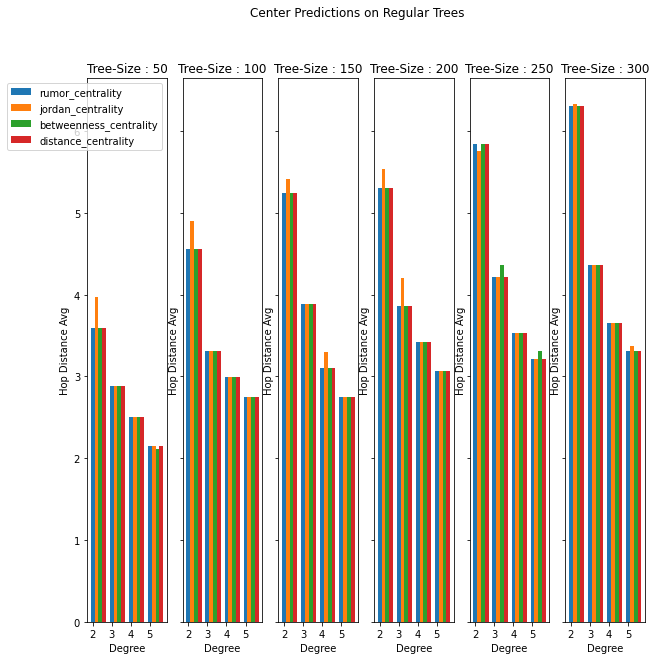

In [37]:
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(10,10))

for i, size in enumerate(sizes):
    ax = axes[i]
    f = [(_degree, _freq) for _degree, _size, _freq in averages if size == _size]    
    for j, metric in enumerate(metrics.keys()):
        x = [_freq[metric] for _degree, _freq in f]
        ax.bar(
            np.array(degrees) + j * 0.2,
            [_freq[metric] for _degree, _freq in f],
            label=metric,
            width=0.2,
        )
    ax.set_title(f"Tree-Size : {size}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Hop Distance Avg")
    
    ax.set_xticks(np.array(degrees))
axes[0].legend()
fig.suptitle("Center Predictions on Regular Trees")

## Geometric Graphs
We do not know what geometric trees are, we therefor create geometric graphs and simulate on them

In [118]:
from tqdm import tqdm

def geo_graph_averages(size, radius):
    g = nx.random_geometric_graph(size, radius)
    read_only = g.copy(as_view=True)
    infected_g, c = si(g, *si_config, max_infected_nodes=0.1 * size)
    
    metric_averages = {}
    with tqdm(total=len(metrics) * samples) as bar:
        for i, (metric_name, metric) in enumerate(metrics.items()):
            hop_distances = []
            for _ in range(samples):
                predicted_c = metric(infected_g)
                hop_distances.append(nx.shortest_path_length(read_only, c[0], predicted_c[0]))
                bar.update(1)
            avg_hop_distance = sum(hop_distances) / samples
            metric_averages[metric_name] = avg_hop_distance
    
    return metric_averages

In [199]:
results = []
sizes = list(range(100, 1000, 100))
for s in tqdm(sizes):
    avgs = geo_graph_averages(s, 0.1)
    results.append((s, avgs))

100%|█████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 6016.01it/s]

 21%|██████████████▎                                                     | 84/400 [00:02<00:08, 36.96it/s]


 15%|██████████▏                                                         | 60/400 [00:02<00:15, 21.87it/s]


 77%|███████████████████████████████████████████████████▊               | 309/400 [00:13<00:03, 30.06it/s]


 60%|████████████████████████████████████████                           | 239/400 [00:07<00:08, 18.91it/s]


 21%|██████████████▎                                                     | 84/400 [00:03<00:12, 25.75it/s]


100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:54<00:00,  6.03s/it]


Text(0.5, 0.98, 'Geo Graphs, Raduis 0.1')

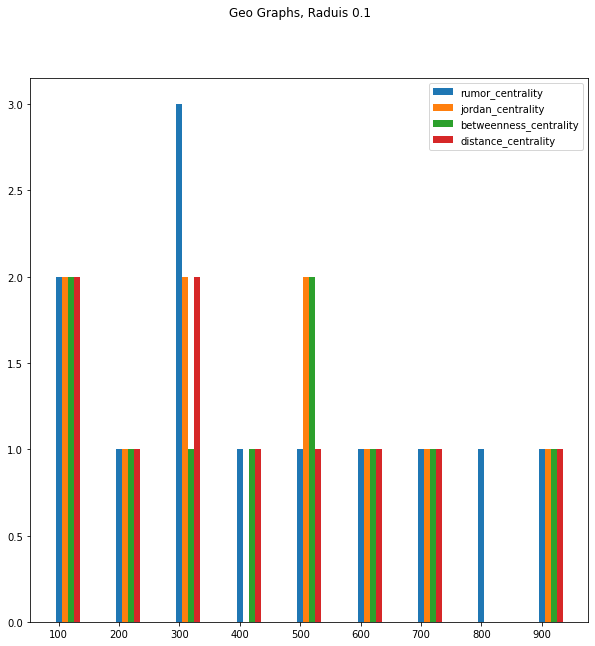

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, metric_name in enumerate(metrics):
    ax.bar(np.array(sizes) + i*10, [d[metric_name] for s, d in results], label=metric_name, width=10)
ax.legend()
ax.set_xticks(np.array(sizes))

fig.suptitle("Geo Graphs, Raduis 0.1")

More nodes seem to make the prediction easier. Predictions are really close to each other.

In [201]:
results_04 = []
sizes = list(range(100, 1000, 100))
for s in tqdm(sizes):
    avgs = geo_graph_averages(s, 0.4)
    results_04.append((s, avgs))

  6%|████                                                                | 24/400 [00:00<00:06, 55.23it/s]


 18%|███████████▉                                                        | 70/400 [00:03<00:18, 18.11it/s]


 77%|███████████████████████████████████████████████████▊               | 309/400 [00:16<00:03, 25.92it/s]


 62%|█████████████████████████████████████████▌                         | 248/400 [00:09<00:10, 14.18it/s]


  8%|█████▊                                                              | 34/400 [00:03<00:42,  8.63it/s]


 33%|██████████████████████                                             | 132/400 [00:12<00:08, 30.72it/s]


 66%|████████████████████████████████████████████▍                      | 265/400 [00:28<00:28,  4.81it/s]


  3%|██                                                                  | 12/400 [00:02<01:04,  6.02it/s]


 22%|██████████████▌                                                     | 86/400 [00:14<00:52,  5.97it/s]


 57%|██████████████████████████████████████▌                            | 230/400 [00:30<00:53,  3.18it/s]


 78%|████████████████████████████████████████████████████▎              | 312/400 [00:52<00:06, 13.72it/s]


100%|███████████████████████████████████████████████████████████████████████| 9/9 [02:22<00:00, 15.84s/it]


Text(0.5, 0.98, 'Geo graphs, Radius 0.4')

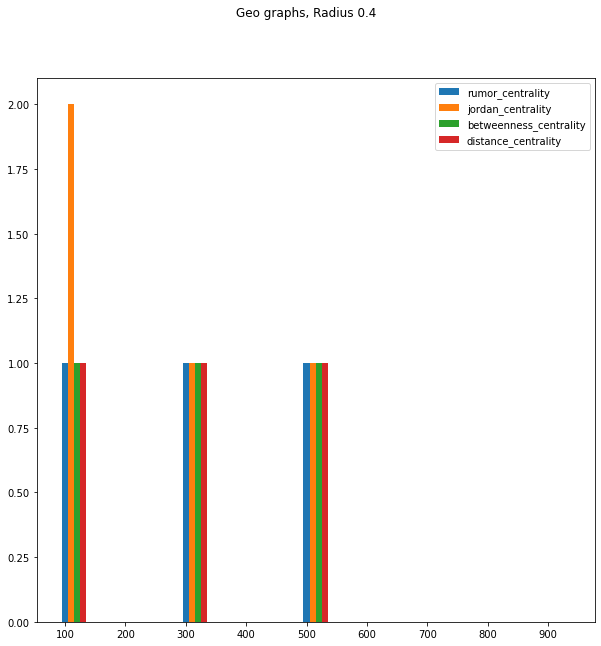

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, metric_name in enumerate(metrics):
    ax.bar(np.array(sizes) + i*10, [d[metric_name] for s, d in results_04], label=metric_name, width=10)
ax.legend()
ax.set_xticks(np.array(sizes))
fig.suptitle("Geo graphs, Radius 0.4")

Higher Connectivity improves predictions results vastly!
Metrics still perform really similar

## General Networks

In [214]:
# General Networks
from tqdm import tqdm

from rumor_centrality.graph_generator import scale_free, small_world
from rumor_centrality.graph_simulations import si

node_count = 5000

In [234]:
# turn small world from multi to simple graph
results = []
for _ in tqdm(range(10)):
    g = nx.Graph(scale_free(node_count))
    read_only = g.copy(as_view=True)
    inf_g, c = si(g, -1, .1, 1, max_infected_nodes=0.1 * node_count)
    predictions = predict_center(inf_g)
    r = dict(map(
        lambda i: (i[0], get_hop_distance(g, c[0], i[1][0])),
        predictions.items(),
    ))
    results.append(r)

100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.93s/it]


In [241]:
values

{'rumor_centrality': [2, 2, 2, 2, 2, 1, 2, 2, 3, 2],
 'jordan_centrality': [3, 2, 2, 2, 2, 1, 2, 3, 3, 2],
 'betweenness_centrality': [2, 2, 2, 2, 2, 1, 2, 3, 3, 2],
 'distance_centrality': [2, 2, 2, 2, 2, 1, 2, 3, 3, 2]}

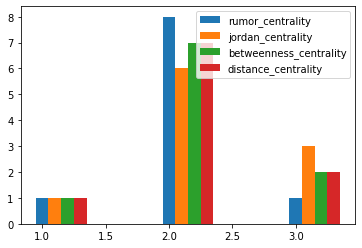

In [258]:
values = {}
for r in results:
    for k, v in r.items():
        values[k] = values.get(k, []) + [v]

uniques = list(set([x for v in values.values() for x in v]))
for i, (k, v) in enumerate(values.items()):
    plt.bar(np.array(uniques) + 0.1 * i, [v.count(u) for u in uniques], width=0.1, label=k)
plt.legend()

## Real World Networks

In [268]:
from rumor_centrality.graph_generator import internet, us_power_grid
import networkx as nx

results = []
for _ in tqdm(range(100)):
    inf_g, c = si(internet(), -1, 0.1, 1, 400)
    predictions = predict_center(inf_g)
    r = dict(map(
        lambda i: (i[0], get_hop_distance(internet(), c[0], i[1][0])),
        predictions.items(),
    ))
    results.append(r)

100%|███████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Text(0.5, 1.0, 'Internet Graph')

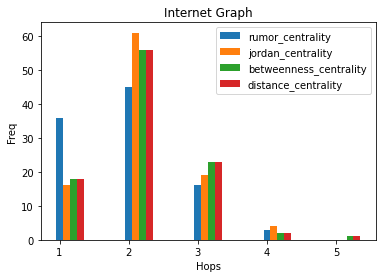

In [285]:
for i, metric_name in enumerate(metrics.keys()):
    r = [x[metric_name] for x in results]
    uniques = list(set(r))
    plt.bar(np.array(uniques) + i * 0.1, [r.count(u) for u in uniques], width=0.1, label=metric_name)
plt.legend()
plt.ylabel("Freq")
plt.xlabel("Hops")
plt.title("Internet Graph")

In [287]:
# Avg Degree
len(internet().edges) / len(internet().nodes)

2.146277417361755

Rumor Centrality has the closest predictions, but there are not perfect matches.

In [286]:
from rumor_centrality.graph_generator import internet, us_power_grid
import networkx as nx

results = []
for _ in tqdm(range(100)):
    inf_g, c = si(us_power_grid(), -1, 0.1, 1, 400)
    predictions = predict_center(inf_g)
    r = dict(map(
        lambda i: (i[0], get_hop_distance(internet(), c[0], i[1][0])),
        predictions.items(),
    ))
    results.append(r)

100%|███████████████████████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.95s/it]


In [288]:
# Avg Degree
len(us_power_grid().edges) / len(us_power_grid().nodes)

1.334547662416515

In [ ]:
for i, metric_name in enumerate(metrics.keys()):
    r = [x[metric_name] for x in results]
    uniques = list(set(r))
    plt.bar(np.array(uniques) + i * 0.1, [r.count(u) for u in uniques], width=0.1, label=metric_name)
plt.legend()
plt.ylabel("Freq")
plt.xlabel("Hops")
plt.title("us_power_grid Graph")

Rumor Centrality and jordan centers have the best predictions. Rumor Centrality a few perfect ones.

# Conclusion

We could not reproduce the papers results.
However, we find that rumor centrality is on par with our chosen alternatives.
We see that the perforance is worse on trees and good on graphs, especially with a avg high degree.
This also shows in the better performance on regular trees with higher degrees.

We therefor test the performance based on the avg. node degree by generating a tree, and adding random edges.

In [380]:
from random import choice

class TooManyRetries(Exception):
    pass

def add_random_edge(g):
    source = choice(list(t.nodes))
    target = choice(list(set(t.nodes) - set(g.neighbors(source))))
    
    g.add_edge(source, target)
    return g    

In [386]:
node_count = 1000
t = nx.random_tree(node_count)

edge_count = len(t.edges)

initial_degree = edge_count / node_count

diff = 0

results = []
while 1:
    add_random_edge(t)
    edge_count += 1
    current_degree = edge_count / node_count
    diff = current_degree - initial_degree
    if diff > 10:
        print(current_degree)
        sample_results = []
        for _ in range(10):
            inf_g, c = si(t.copy(), -1, 0.1, 1, 400)
            predictions = predict_center(inf_g)
            r = dict(map(
                lambda i: (i[0], get_hop_distance(t, c[0], i[1][0])),
                predictions.items(),
            ))
            sample_results.append(r)
            
        results.append((current_degree, sample_results))
            
        initial_degree = current_degree
    if current_degree > 400:
        break

11.0
21.001
31.002
41.002
51.003
61.004


KeyboardInterrupt: 

In [399]:
averages_over_time = {}

for degree, r in results:
    values = {}
    for sample in r:
        for k, v in sample.items():
            values[k] = values.get(k, []) + [v]
    averages = {}
    for k, v in values.items():
        averages_over_time[k] = averages_over_time.get(k, []) + [sum(v) / len(v)]

Text(0.5, 0, 'degree')

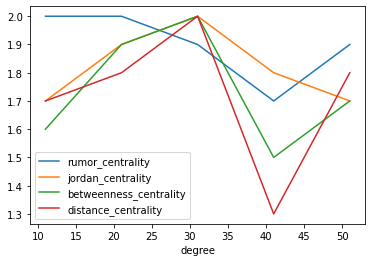

In [411]:
for k, averages in averages_over_time.items():
    plt.plot([r[0] for r in results], averages, label=k)
plt.legend()
plt.xlabel("degree")
plt.ylabel("degree")